# Chap06 - Decision Tree

**Desicion Tree**(이하, 결정 트리 또는 의사결정나무)는 **분류**와 **회귀**에 사용할 수 있는 머신러닝 알고리즘이다. 

이번 장에서는 결정 트리의 훈련, 시각화, 예측 방법에 대해 알아보고, 결정 트리 중 Scikit-Learn의 CART 알고리즘을 알아보고 트리에 규제를 적용하는 방법과 회귀 문제에 적용하는 방법에 대해 알아 보도록 하자.

## Set Up

In [1]:
import os
import numpy as np

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
matplotlib.rc('font', family='AppleGothic')  # MacOS
#matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴드
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

$conda install python-graphviz

### (참고) 

#### 결정 트리는 트리 구조의 분류기

- 결정 노드: 단일 특성에 대해 데이터를 테스트

- 말단 노드: 클래스

- 엣지: 하나의 특성 값을 분류

- 경로(path): 최종 분류 결정을 하기 위한 rule의 논리합(disjuction)

#### 결정 트리 구축 원칙

- 각 노드에서 테스트할 특성 선택: 분류할 때 가장 유용한 특성 순서대로 선택

- 정보 획득량

- : 각 특성들이 훈련 예제들을 얼만큼 잘 분류할 수 있는가를 수치적으로 측정

- : 트리 구축 과정에서 테스트 후보 특성의 순서를 결정할 때 사용

#### 결정 트리 분류의 특징

**장점**

- 다른 분류 방법에 비해서 상대적으로 빠름 (분류 시 계산량이 적음)

- 간단하고 모델 구축 원리를 이해하기 쉬움

- 모델의 분류 룰(rule)을 사람이 직관적으로 이해하기 쉬움
 : 어느 특성이 분류에 가장 중요한지 명확히 나타냄

- 다른 모델들에 비해서 더 좋은 성능 나타낼 때가 있음 

**단점**

- 연속적인 특성 값을 갖는 데이터에 적합하지 않음

- 클래스의 개수가 많고 데이터가 적을 때 성능이 좋지 않음

- 훈련과정에서 계산량이 많음

- 트리의 노드 선택 순서를 정하기 위해 모든 특성의 정보 획득량을 계산한 뒤, 정렬해야 함

**CART vs ID3  알고리즘**

|    특징       |   CART                                                      |     ID3    |
|-------------|-----------------------| ----------------------------------|
|  분류기준    |  Gini Index                                              |  Shannon entropy   |
|             |       |                                                                |  Information gain   |
|   분류방식    |  이진 트리를 사용                                     |  Field별 값을 기준으로 분할   |
|                    |  1개의 field 값을 특정 기준값을 기준으로,   |  Grade라는 field에 (A, B, C)라는 값이 있으면,  |
|                    |  크면 right, 작으면 left로 분류                   |  각 송성별로 데이터를 분류함 (총 3번) |
|   지원모델    |   Classification                                         |  Classification + Regression |

|     특징       |   CART                                                      |     ID3    
|------------| ---------------------------------------| -----------------------------------------
|   분류기준    |  Gini Index                                              |  Shannon entropy
|          .          |                            .                                    |  Information gain
|   분류방식    |  이진 트리를 사용                                     |  Field별 값을 기준으로 분할
|          .          |  1개의 field 값을 특정 기준값을 기준으로,   |  Grade라는 field에 (A, B, C)라는 값이 있으면,
|          .          |  크면 right, 작으면 left로 분류                   |  각 송성별로 데이터를 분류함 (총 3번)
|   지원모델    |   Classification                                         |  Classification + Regression

| 특징                 | CART                 | ID3          |
| :------------------- | -------------------: |:---------------:|
|  분류기준 |  Gini index | Shannon entropy |
|   |   | Information gain |
| $100                 | $100                 | $100            |
| $10                  | $10                  | $10             |
| $1                   | $1                   | $1              |

## 6.1 결정 트리 학습과 시각화

다음 예제는 붓꽃(iris) 데이터셋을 Scikit-Learn의 [`DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)를 이용해 학습시키는 코드이다.

> Scikit-Learn은 **이진 트리**만 만드는 **CART** 알고리즘을 사용하기 때문에, 리프 노드를 제외한 모든 노드는 자식노드를 2개씩 가진다(조건에 대해, 'yes' or 'no'). 하지만, **ID3** 알고리즘을 이용해 2개 이상의 자식 노드를 가지는 결정트리를 만들 수 있다.  

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [3]:
from sklearn.tree import export_graphviz

export_graphviz(tree_clf, 
                out_file='./images/iris_tree.dot', 
                feature_names=["꽃잎 길이 (cm)", "꽃잎 너비 (cm)"], 
                class_names=iris.target_names, 
                rounded=True, 
                filled=True)

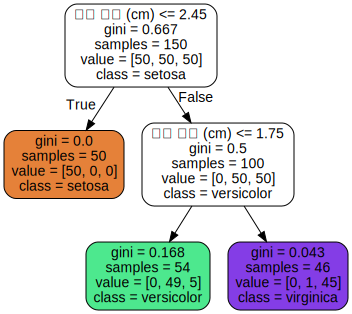

In [4]:
import graphviz

with open("./images/iris_tree.dot", encoding='UTF8') as f:
    dot_graph = f.read()
dot = graphviz.Source(dot_graph)
dot.format = 'png'
dot.render(filename='iris_tree', directory='./images', cleanup=True)
dot

위의 그래프에서 노드의 각 속성에 대한 설명은 다음과 같다.

- `sample` : 각 노드로 분류된 데이터의 개수를 말한다.
- `value` : 각 노드에서 label(여기서는 `setosa, versicolor, virginica`)에 속하는 데이터의 개수를 말한다.
    - 예를 들어, 왼쪽 주황색 노드는 `setosa`가 50개, `versicolor, virginica`는 0개를 의미한다.

- `gini` : **불순도**(impurity)를 의미하며, 불순도를 측정하는 지표인 **지니(gini)** 계수를 이용한다.
    - 예를 들어, level 2의 초록색 노드의 gini 계수는 $1-(\frac{0}{54})^{2} - (\frac{49}{54})^{2} - (\frac{5}{54})^{2} \approx 0.168$ 이다. 

- Gini 계수의 수식은 다음과 같다.

$$
G_i = 1 - \sum_{k=1}^{n}{p_{i,k}^{2}}
$$

- $p_{i, k}$ 는 $i$번째 노드에 있는 데이터 중 클래스 $k$에 속한 샘플의 비율이다.

## 6.2 예측하기

Decision Tree를 이용한 분류기가 어떻게 붓꽃의 종류를 예측하는지에 대해 위의 그래프(graphviz)를 통해 알아보자. 

1. 맨위의 노드인 **루트 노드**(root node)에서 꽃잎의 길이(petal length)가 `2.45cm`보다 짧은지 비교한다.
2. `2.45cm`보다 짧다면 왼쪽 노드(주황색)인 **자식 노드**(child node)로 이동한다.
    - 이 경우에는 더 이상의 자식 노드가 없으므로 **리프 노드**(leaf node)가 된다.
    - 그리고, 꽃의 종류를 `setosa`라고 예측한다.
3. 반대로, `2.45cm` 보다 긴 경우 오른쪽 자식 노드로 가며, 꽃잎 너비가 `1.75cm` 보다 짧은지 비교하게 된다. 
4. 꽃잎의 너비가 `1.75cm` 보다 짧으면 왼쪽 리프 노드(초록색)로 가게되며, `versicolor`라고 예측하며, `1.75cm` 보다 길면, 오른쪽 리프 노드(보라색)으로 가게되며, `virginica`로 예측한다. 

> Decision Tree 의 장점은 데이터 전처리가 거의 필요하지 않다는 것이며, 특히 특성(feature)의 스케일을 맞추거나 평균을 원점에 맞추는 작업(`StandardScaler`)이 필요하지 않다.

아래의 예제는 위의 결정 트리에 대한 결정 경계(decision boundary)를 보여준다. 

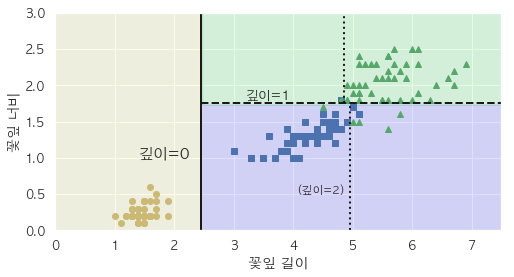

In [5]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("꽃잎 길이", fontsize=14)
        plt.ylabel("꽃잎 너비", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "깊이=0", fontsize=15)
plt.text(3.2, 1.80, "깊이=1", fontsize=13)
plt.text(4.05, 0.5, "(깊이=2)", fontsize=11)

plt.show()

#### 화이트박스 vs 블랙박스

위에서 확인할 수 있듯이, 결정 트리 모델은 매우 직관적이며, 모델의 예측 즉, 결정 방식을 이해하기 쉽다. 이러한 모델을 **화이트박스**(white box) 모델이라고 한다. 반대로, 추후에 다룰 랜덤포레스트나 신경망은 이러한 결정 방식을 이해하기에는 어렵기 때문에 **블랙박스**(black box)모델이라 한다.

## 6.3 클래스 확률 추정

결정 트리는 어떤 하나의 데이터(샘플)이 특정 클래스 $k$에 분류될 확률을 추정(계산)할 수 있다. 확률을 추정하는 방법은 각 리프 노드의 클래스 $k$의 비율을 계산하여 구할 수 있다.

예를 들어, 꽃잎의 길이가 5cm이고, 너비가 1.5cm인 경우에는 위의 그래프에서 초록색 노드로 분류될 것이다. 이러한 확률을 계산하면, $\text{setosa} = \frac{0}{54} = 0$, $\text{versicolor} = \frac{49}{54} = 0.907$, $\text{virginica} = \frac{5}{53} = 0.093$ 이다.

따라서, 결정 트리는 꽃잎의 길이가 5cm이고, 너비가 1.5cm인 꽃은 `Versicolor`로 예측할 것이다.

In [6]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [7]:
tree_clf.predict([[5, 1.5]])

array([1])

## 6.4 CART 알고리즘

Scikit-Learn은 결정 트리 알고리즘 중 **CART**(Classification And Regression Tree)알고리즘을 사용한다. 

CART 알고리즘은 먼저 학습 데이터셋(train set)을 하나의 특성(feature) $k$의 임계값 $t_k$를 사용해 두 개의 서브셋(child node)로 나눈다. 

예를 들어, 위의 그래프에서 루트 노드(root node)는 꽃잎의 길이(petal length)라는 특성을 임계값 2.45로 (**꽃잎의 길이 $\le$ 2.45cm**)로 `True/False`로 나눴다. 

CART 알고리즘의 비용 함수(cost function)는 다음과 같다.

$$
J\left(k, t_k \right) = \frac{m_{\text{left}}}{m} G_{\text{left}} + \frac{m_{\text{right}}}{m} G_{\text{right}}
$$

- $G_{\text{left/right}}$ : 왼쪽/오른쪽 자식노드의 불순도(지니계수)
- $m_{\text{left/right}}$ : 왼쪽/오른쪽 자식노드의 데이터(샘플) 수

이와 같은 방법으로 자식 노드(subset)로 나누는 과정을 결정 트리의 최대 깊이(sklearn에서는 `max_depth` 인자) 또는 불순도를 줄일 수 있는 분할을 찾을 수 없을 때까지 반복한다.

이렇듯 CART 알고리즘은 각 단계 즉, 각 노드에서 그 다음 자식 노드로 분할할때 가장 좋은 최적의 분할만 찾아갈 뿐, 현재 단계의 분할이 몇 단계를 거쳐 가장 낮은 불순도가 될지는 고려하지 않는다. 이러한 알고리즘을 **탐욕적 알고리즘**(greedy algorithm)이라고 한다.

따라서, 최적의 결정 트리를 찾는 것은 **NP-완전**(NP-Complete)문제이며, $O(\exp{(m)})$시간이 필요하다. 따라서, 교재의 표현처럼 *납득할만한 좋은 솔루션* 으로만 만족해야 한다.

## 6.5 계산 복잡도

결정 트리에서 예측을 하기 위해서는 루트 노드에서부터 리프 노드까지 탐색해야 한다. 일반적인 결정 트리는 대부분 좌/우 균형을 이루기 때문에 약 $O(\log_{2}{(m)})$ 개의 노드를 탐색해야 한다.

각 노드는 하나의 특성값만 확인하기 때문에 예측에 필요한 전체 시간 복잡도는 특성의 개수와 무관하게 $O(\log_{2}{(m)})$이다. 따라서, 예측 속도는 매우 빠르다.

반면, 학습 단계에서는 각 노드마다 모든 데이터를 모든 특성($n$)에 비교하므로, 학습 단계에서의 복잡도는 $O(n \times m \log{(m)})$이다. 따라서, 학습 단계에서의 속도는 데이터의 크기가 클 수록 느리다.

## 6.6 지니 불순도 또는 엔트로피?

의사결정나무는 '6.4 - CART 알고리즘'에서 알아 보았듯이, 학습 데이터셋(train set)을 하나의 특성(feature)을 가지고 두 개의 서브셋(child node)로 나누는 알고리즘 이다. 

이렇게 하나의 특성에서 두 개의 서브셋으로 나누는 기준은 **불순도(impurity)**를 **최소**(또는, 순도, homogeneity를 최대)로 하는 것이다. 이렇게 불순도 즉, 불확실성이 감소하는 것을 정보이론에서는 **정보획득**(Information Gain)이라고 한다.

Scikit-Learn의 [`DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)에서는 기본값(default)으로 지니 계수(`Gini`)가 사용되지만, `criterion` 인자를 `"entropy"`로 설정하면, **엔트로피** 지표를 사용할 수 있다. 

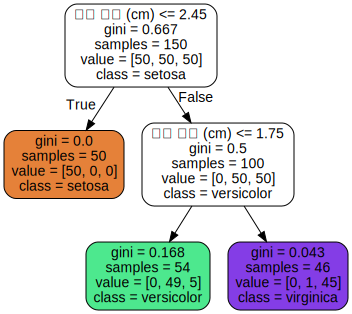

In [8]:
import graphviz

with open("./images/iris_tree.dot", encoding='UTF8') as f:
    dot_graph = f.read()
dot = graphviz.Source(dot_graph)
dot.format = 'png'
dot.render(filename='iris_tree', directory='./images', cleanup=True)
dot

지니계수와 엔트로피 계수는 다음과 같다.

#### 지니 계수

$$
G_i = 1 - \sum_{k=1}^{n}{p_{i,k}^{2}}
$$

- $p_{i, k}$ 는 $i$번째 노드에 있는 데이터 중 클래스 $k$에 속한 샘플의 비율이다.
- 예를 들어, level 2의 초록색 노드의 gini 계수는 $1 - (\frac{49}{54})^{2} - (\frac{5}{54})^{2} \approx 0.168$ 이다. 

#### 엔트로피 계수

$$
H_i = - \sum_{\underset{p_{i,k} \neq 0}{k=1}}^{n}{p_{i,k} \log_{2}{\left( p_{i, k} \right)}}
$$

- 예를 들어,  level 2의 초록색 노드의 엔트로피 계수는 $-\frac{49}{54} \log_{2}{\left( \frac{49}{54} \right)} -\frac{5}{54} \log_{2}{\left( \frac{5}{54} \right)} \approx 0.445$ 이다.

#### 둘 중 어느 계수를 사용할까?

지니(Gini)나 엔트로피(Entropy) 계수 둘 다 비슷한 트리를 만든다. 지니 계수가 계산이 조금 더 빠르기 때문에 Scikit-Learn에서는 지니 계수를 기본값을 사용한다. 

하지만, 지니 계수는 가장 빈도가 높은 클래스를 한쪽 가지(branch)로 고립시키는 경향이 있다고 한다.

## 6.7 규제 매개변수

의사결정나무는 학습(또는 훈련) 데이터에 대한 제약이 거의 없기 때문에 학습 데이터에 오버피팅(overfitting, 과대적합)되기 쉽다. 의사결정나무는 모델 파라미터가 없는 것이 아니라 학습 전에 파라미터 개수가 결정되지 않기 때문에, 이러한 모델을 **비파라미터 모델**(nonparametric model)이라 부르기도 한다. 

의사결정나무 모델이 학습 데이터에 과적합 되는 것을 방지하기 위해 몇 가지 규제(regularization)가 있는데, 일반적으로 결정 트리의 **깊이(depth)**를 조절한다. Scikit-Learn에서는 `max_depth` 인자로 트리의 깊이를 설정할 수 있다. 

[`DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)에서는 트리의 깊이(`max_depth`) 뿐만 아니라 규제를 하기위한 다른 인자들이 있다. 아래의 매개변수에서 `min_`으로 시작하는 매개변수를 증가 시키거나, `max_`로 시작하는 매개변수를 감소시키면 모델에 규제가 **커진다**.

- `min_samples_split` : 분할되기 위해 노드가 가져야 하는 최소 샘플(데이터) 수
- `min_samples_leaf` : 리프 노드가 가지고 있어야 하는 최소 샘플 수
- `min_weight_fraction_leaf` : `min_samples_leaf`와 같지만 가중치가 부여된 전체 샘플 수에서의 비율
- `max_leaf_nodes` : 리프 노드의 최대 개수
- `max_features` : 각 노드에서 분할에 사용할 특성의 최대 수

**장점**
- 작은 트리일 때 시각화가 좋아 설명하기 쉽다.
- 특성이 각각 처리되므로 데이터 스케일에 구애 받지 않는다. 정규화나 표준화 같은 전처리 과정이 필요 없다.
- 이진 특성이나 연속적인 특성이 혼합되어 있어도 가능하다.

**단점**
- 과대적합 가능성 높아 일반화 성능이 좋지 않다.

아래의 예제는 sklearn의 `moons` 데이터셋에 위의 매개변수 중 `min_samples_leaf`(리프 노드의 최소 샘플 수) 매개변수를 다르게 하여 결정 트리를 학습시킨 것이다.

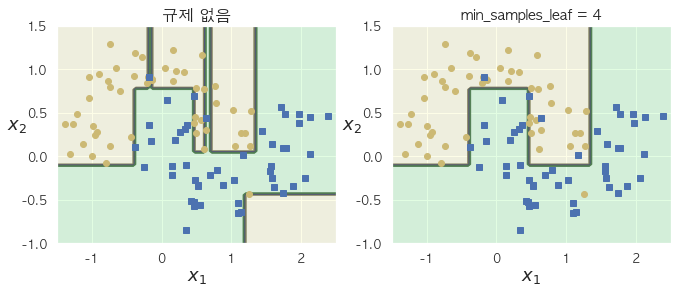

In [9]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("규제 없음", fontsize=16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)

plt.show()

### 가지치기(pruning)

**가지치기**(pruning)는 결정트리를 아무런 규제 없이 학습 시킨 뒤 불필요한 노드를 제거하는 방법을 말하며, 마치 나무에서 불필요한 가지를 자르는 것과 같기 때문에 가지치기라 한다.

불순도를 최소화하는 것이 **통계적으로** 효과가 없다면 리프 노드는 필요없는 노드라 할 수 있다. 이렇게 판단하는 기준은 **$\chi^{2}$ 검정**(chi-squared, 카이 제곱검정)을 사용하며, **$p$-value** 값이 $0.05$보다 높으면 해당 노드는 불필요한 노드로 추정하여 해당 노드의 자식 노드를 가지치기 한다.

## 6.8 회귀(Regression)

의사결정나무는 회귀(regression)문제에도 사용할 수 있다. Scikit-Learn에서는 `DecisionTreeRegressor`를 이용해 회귀 트리를 모델링할 수 있다.

아래의 예제는 아래의 식

$$
y = 4 \left( x - 0.5 \right)^{2} + \text{noise}
$$

헝태의 임의의 데이터셋을 만들어 `max_depth=2`로 설정하여 회귀트리를 만든 것이다.

In [10]:
# 2차식으로 만든 데이터셋 + 잡음
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [11]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

다음은 `max_depth=2`와 `max_depth=3`을 비교한 것이다.

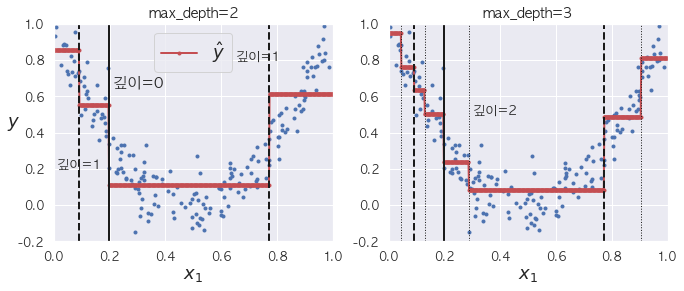

In [12]:
tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "깊이=0", fontsize=15)
plt.text(0.01, 0.2, "깊이=1", fontsize=13)
plt.text(0.65, 0.8, "깊이=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.subplot(122)
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "깊이=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

plt.show()

In [13]:
export_graphviz(
        tree_reg1,
        out_file="./images/regression_tree.dot",
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

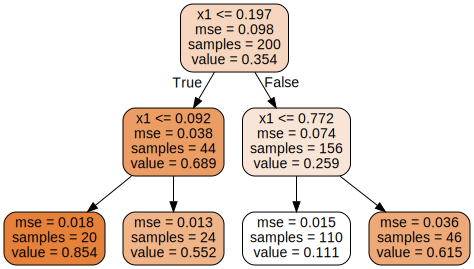

In [14]:
import graphviz
with open("./images/regression_tree.dot") as f:
    dot_graph = f.read()
dot = graphviz.Source(dot_graph)
dot.format = 'png'
dot.render(filename='regression_tree', directory='./images/decision_trees', cleanup=True)
dot

위의 회귀 트리 그래프에서 확인할 수 있듯이, 분류 트리와 비슷한 모양인 것을 알 수 있다. 다만, 회귀 트리는 각 노드에서 클래스를 예측하는 것이 아니라 특정 **값**을 예측한다.

예를들어 $x_1=0.6$인 데이터의 값을 예측한다고 했을 때, 위의 그래프를 따라 가다보면, $\text{value} = 0.111$이 되며, 해당 노드의 110개의 샘플의 평균값이 예측값이 된다. 그리고 이 110개의 샘플에 대한 MSE값이 0.015이다.

CART 알고리즘은 학습 데이터셋을 평균제곱오차(MSE)를 최소화하도록 트리를 분할한다.

$$
J\left(k, t_k \right) = \frac{m_{\text{left}}}{m} \text{MSE}_{\text{left}} + \frac{m_{\text{right}}}{m} \text{MSE}_{\text{right}}
$$

$$
\begin{cases} \text{MSE}_{\text{node}} = \sum_{i \in \text{node}}{\left( \hat{y}_\text{node} - y_i \right)^{2}} \\ \hat{y}_\text{node} = \frac{1}{m_\text{node}}\sum_{i \in \text{node}}{y_i} \end{cases}
$$

회귀 트리 또한 분류 트리처럼 과적합되기 쉽다. 아래의 예제는 규제가 없는 경우와 `min_sample_leaf=10`을 지정한 경우에 대한 차이를 나타낸 것이다.

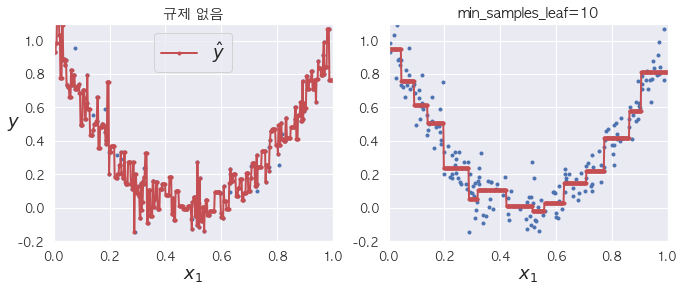

In [15]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("규제 없음", fontsize=14)

plt.subplot(122)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

plt.show()

## 6.9 불안정성

의사결정나무 모델은 이해하고 해석하기 쉽고, 분류 및 회귀에 사용할 수 있을 뿐만아니라 성능도 좋다. 하지만, 위의 예제코드의 그래프에서 보았듯이, 결정 트리는 계단 모양의 결정 경계(decision boundary)를 만든다. 따라서, 학습 데이터셋의 회전(rotation)에 민감하다. 아래의 예제에서 오른쪽 그래프는 데이터셋을 45°도 회전시킨 후 결정 트리 모델링을 한 것이다.

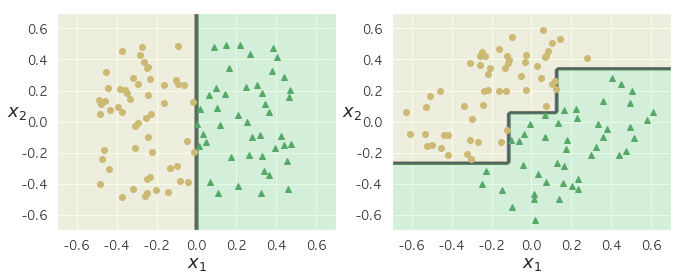

In [16]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.subplot(122)
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)

plt.show()

### 학습 데이터 셋에 민감함

결정 트리의 주된 문제는 학습 데이터셋의 변화에 민감하다는 것이다. 아래의 예제는 붓꽃(iris) 데이터 셋에서 `Versicolor` 종류 중에서 `sepal width`가 가장 큰 데이터들을 지우고 결정 트리 모델링을 한 결과이다. 그림에서 볼 수 있듯이, 6.2의 결과와는 다른것을 알 수 있다.

In [17]:
iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)
X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)] # 가장 너비가 큰 Iris-Versicolor

array([[4.8, 1.8]])

In [18]:
not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=40,
            splitter='best')

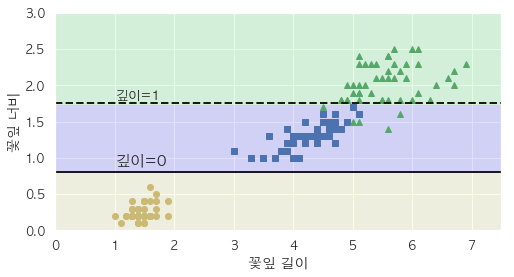

In [19]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "깊이=0", fontsize=15)
plt.text(1.0, 1.80, "깊이=1", fontsize=13)

plt.show()

## 6.10 연습문제

**1. 백만 개의 샘플을 가진 훈련 세트에서 (규제 없이) 훈련시킨 결정 트리의 깊이는 대략 얼마일까요?**

m개의  리프 노드를 포함한 균형이 잘 잡힌 이진 트리의 깊이는 $log_2(m)$을 반올림한 것과 같음. 제한을 두지 않고 훈련시키면 훈련 샘플마다 하나의 리프 노드가 되므로 어느 정도 균형이 잘 잡힌 트리가 된다. 따라서 백만개의 샘플이 있을때 완벽하게 균형잡힌 트리가 아닐 경우 결정 트리의 깊이는 $log_2(10^6)  \approx 20$이 조금 넘게 된다.

**2. 한 노드의 지니 불순도가 보통 그 부모 노드보다 작을까요 클까요?**

한 노드의 지니 불순도는 일반적으로 부모의 불순도마다 낮음.

**3. 결정 트리가 훈련 세트에 과대적합되었다면 max_depth를 줄이는 것이 좋을까요?**

네

**4. 결정 트리가 훈련 세트에 과소적합되었다면 입력 특성의 스케일을 조정하는 것이 좋을까요?**

결정 트리는 훈련 데이터의 스케일이나 원점에 맞추어져 있는지 상관 없으므로 시간 낭비이다.

**5. 백만 개의 샘플을 가진 훈련 세트에 결정 트리를 훈련시키는 데 한 시간이 걸렸다면, 천만개의 샘플을 가진 훈련 세트에 결정 트리를 훈련시키는 데는 대략 얼마나 걸릴까요?**

$K = (n x 10m log(m)) / (n x m x log(m)) = 10 x log(10m)/log(m)$ 배 늘어난다. $m=10^6$이면 $K \approx 11.7$이므로 훈련에 대략 11.7 시간이 걸릴 것으로 예상 할 수 있음

**6. 십만 개의 샘플을 가진 훈련 세트가 있다면 presort=True로 지정하는 것이 훈련 속도를 높일까요?**

수천개 미만일 때는 속도를 높일 수 있으나 십만개 샘플에 대해는 훈련 속도가 매우 느려질 것이다.


**7. moons 데이터셋에 결정 트리를 훈련시키고 세밀하게 튜닝해보세요.**

a. `make_moons(n_samples=1000, noise=0.4)`를 사용해 데이터셋을 생성합니다.

`random_state=42`를 지정하여 결과를 일정하게 만듭니다:

In [20]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

b. 이를 `train_test_split()`을 사용해 훈련 세트와 테스트 세트로 나눕니다

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

c. `DecisionTreeClassifier`의 최적의 매개변수를 찾기 위해 교차 검증과 함께 그리드 탐색을 수행합니다(`GridSearchCV`를 사용하면 됩니다). 힌트: 여러 가지 `max_leaf_nodes` 값을 시도해보세요.

In [22]:
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, cv=3, n_jobs=-1, verbose=1)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 110 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 882 out of 882 | elapsed:    8.9s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], 'min_samples_split': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       s

In [23]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=17,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

d. 찾은 매개변수를 사용해 전체 훈련 세트에 대해 모델을 훈련시키고 테스트 세트에서 성능을 측정합니다. 대략 85~87%의 정확도가 나올 것입니다.

기본적으로 `GridSearchCV`는 전체 훈련 세트로 찾은 최적의 모델을 다시 훈련시킵니다(`refit=False`로 지정해서 바꿀 수 있습니다). 그래서 별도로 작업할 필요가 없습니다. 모델의 정확도를 바로 평가할 수 있습니다:

In [24]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8695

**8. 랜덤 포레스트를 만들어보세요.**

a. 이전 연습문제에 이어서, 훈련 세트의 서브셋을 1,000개 생성합니다. 각각은 무작위로 선택된 100개의 샘플을 담고 있습니다. 힌트: 사이킷런의 `ShuffleSplit`을 사용할 수 있습니다.

In [25]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

b. 앞에서 찾은 최적의 매개변수를 사용해 각 서브셋에 결정 트리를 훈련시킵니다. 테스트 세트로 이 1,000개의 결정 트리를 평가합니다. 더 작은 데이터셋에서 훈련되었기 때문에 이 결정 트리는 앞서 만든 결정 트리보다 성능이 떨어져 약8 0%의 정확도를 냅니다.

In [26]:
from sklearn.base import clone

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.8054499999999999

c. 이제 마술을 부릴 차례입니다. 각 테스트 세트 샘플에 대해 1,000개의 결정 트리 예측을 만들고 다수로 나온 예측만 취합니다(사이파이의 `mode()` 함수를 사용할 수 있습니다). 그러면 테스트 세트에 대한 _다수결 예측_이 만들어집니다.

In [27]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [28]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

d. 테스트 세트에서 이 예측을 평가합니다. 앞서 만든 모델보다 조금 높은(약 0.5~1.5% 정도) 정확도를 얻게 될 것입니다. 축하합니다. 랜덤 포레스트 분류기를 훈련시켰습니다!

In [29]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.872